# Attention Entropy

I want to look at how the attention is divided using entropy. The idea is that if the attention is spread out over many cells, the entropy will be high, and if the attention is focused on a few cells, the entropy will be low.

I already did this a while ago, but I think it's nice to revisit with the new results.

Maybe, if this shows high entropy, I can look into something like entropy regularization for the attention scores.

In [5]:
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.sparse as sp

from tqdm import tqdm

sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [6]:
FILE = "out/results/GAT_2024-11-01-16-19-45_results_0.h5ad"

In [7]:
adata = ad.read_h5ad(FILE)

In [8]:
FOLD = 0
N_HEADS_1 = adata.uns["att_1_f0_val"]['10100574'].shape[1]
N_HEADS_2 = adata.uns["att_2_f0_val"]['10100574'].shape[1]
DONORS = sorted(adata.obs['Donor ID'].unique())

In [16]:
h_unif = np.zeros(len(adata))  # Uniform attention entropy (same for all heads)
degree = np.zeros(len(adata))  # Node degrees

donor_offset = 0
for donor in tqdm(DONORS):
    donor_adata = adata[adata.obs['Donor ID'] == donor]
    donor_idx = donor_adata.obs.index

    # Degree (requires a first pass)
    pos = adata.uns["att_1_f0_pos"][str(donor)]
    for i in range(pos.shape[1]):
        recv, send = pos[:, i]
        degree[donor_offset + send] += 1

    # Now we use the degree to compute the uniform attention for all nodes
    for i in range(pos.shape[1]):
        recv, send = pos[:, i]
        sent_att = 1 / degree[donor_offset + send]  # Attention if it was distributed uniformly
        h_unif[donor_offset + send] -= sent_att * np.log(sent_att)

    donor_offset += len(donor_adata)

100%|██████████| 339/339 [04:22<00:00,  1.29it/s]


In [ ]:
h_l1 = np.zeros((len(adata), N_HEADS_1))  # Attention entropy in layer 1
h_l2 = np.zeros((len(adata), N_HEADS_2))  # Attention entropy in layer 2
h_unif = np.zeros(len(adata))  # Uniform attention entropy (same for all nodes)
degree = np.zeros(len(adata))  # Node degrees

donor_offset = 0
for donor in tqdm(DONORS):
    donor_adata = adata[adata.obs['Donor ID'] == donor]
    donor_idx = donor_adata.obs.index

    # Degree
    pos = adata.uns["att_1_f0_pos"][str(donor)]
    val = adata.uns["att_1_f0_val"][str(donor)]
    for i in range(pos.shape[1]):
        recv, send = pos[:, i]
        degree[donor_offset + send] += 1
  
    # Layer 1
    pos = adata.uns["att_1_f0_pos"][str(donor)]
    val = adata.uns["att_1_f0_val"][str(donor)]
    for i in range(pos.shape[1]):
        recv, send = pos[:, i]
        h_l1[donor_offset + send] -= val[i] * np.log(val[i])
        
    # Layer 2
    pos = adata.uns["att_2_f0_pos"][str(donor)]
    val = adata.uns["att_2_f0_val"][str(donor)]
    for i in range(pos.shape[1]):
        recv, send = pos[:, i]
        h_l2[donor_offset + send] -= val[i] * np.log(val[i])

    donor_offset += len(donor_adata)

unif_att = 1 / degree
h_unif = -unif_att * np.log(unif_att)

100%|██████████| 339/339 [07:44<00:00,  1.37s/it]


<Axes: ylabel='Count'>

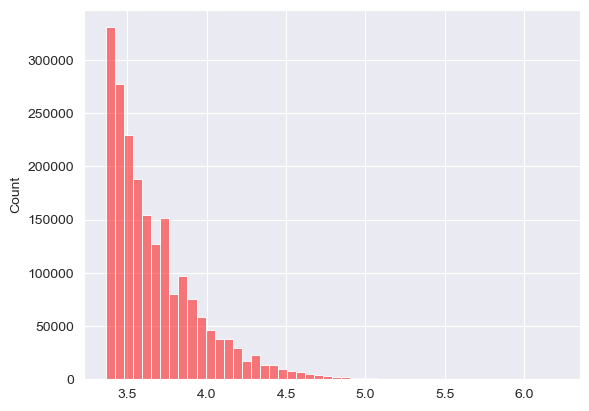

In [20]:
sns.histplot(h_unif, kde=False, color='red', alpha=0.5, bins=50)

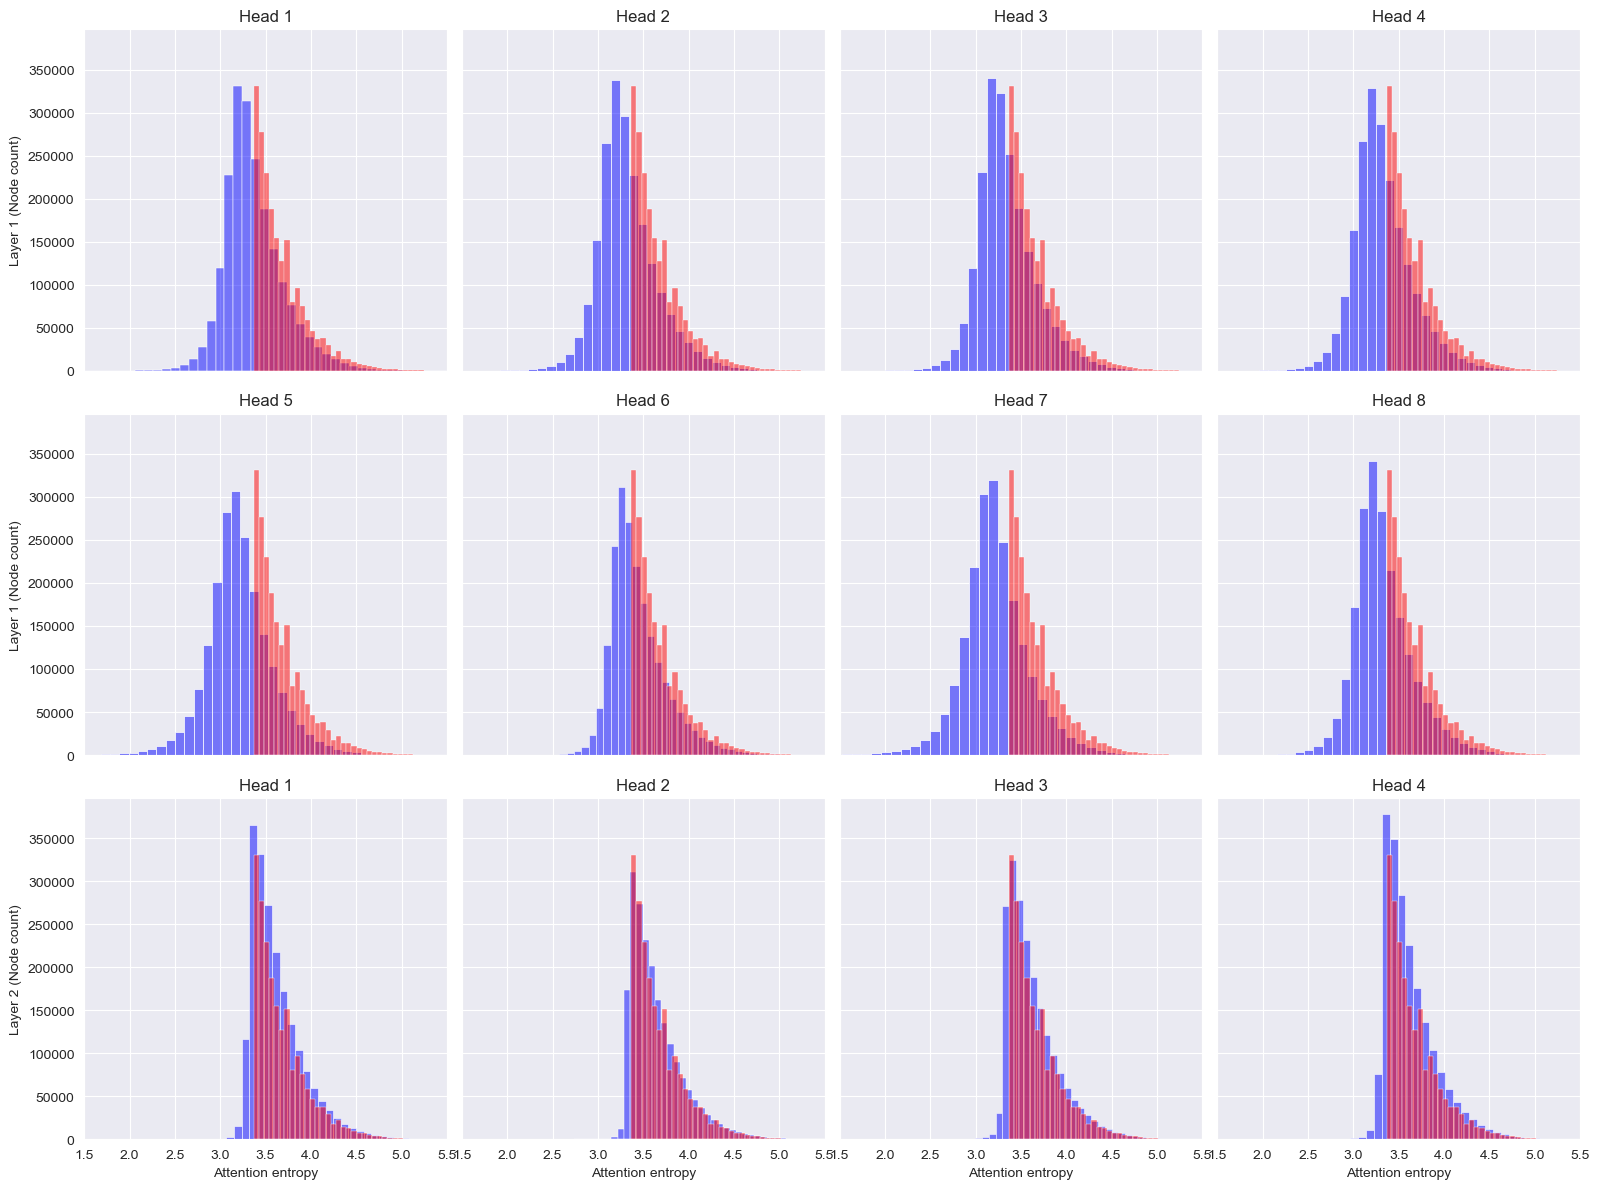

In [32]:
# Now we plot them for each head (12 total, so 3 x 4)

fig, axs = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)

for i in range(N_HEADS_1):
    ax = axs[i // 4, i % 4]
    sns.histplot(h_l1[:, i], kde=False, ax=ax, color='blue', alpha=0.5, bins=50)
    sns.histplot(h_unif, kde=False, ax=ax, color='red', alpha=0.5, bins=50)
    ax.set_title(f"Head {i + 1}")

    ax.set_xlim([1.5, 5.5])

for i in range(N_HEADS_2):
    ax = axs[(i // 4) + 2, i % 4]
    sns.histplot(h_l2[:, i], kde=False, ax=ax, color='blue', alpha=0.5, bins=50, legend=True)
    sns.histplot(h_unif, kde=False, ax=ax, color='red', alpha=0.5, bins=50, legend=True)
    ax.set_title(f"Head {i + 1}")

    ax.set_xlim([1.5, 5.5])

axs[0, 0].set_ylabel("Layer 1 (Node count)")
axs[1, 0].set_ylabel("Layer 1 (Node count)")
axs[2, 0].set_ylabel("Layer 2 (Node count)")

axs[2, 0].set_xlabel("Attention entropy")
axs[2, 1].set_xlabel("Attention entropy")
axs[2, 2].set_xlabel("Attention entropy")
axs[2, 3].set_xlabel("Attention entropy")

plt.tight_layout()
# plt.savefig("out/figures/attention_entropy.pdf")
plt.show()

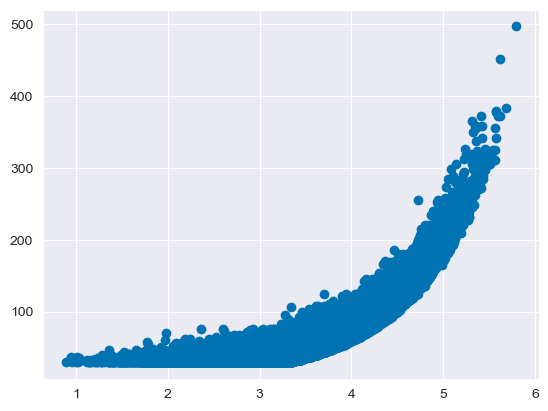

In [29]:
plt.scatter(
    h_l1[:, 0],
    degree,
)